In [62]:
import numpy as np
import os
import pickle
import LibFMP.B
import LibFMP.C4 

%matplotlib inline
import matplotlib.pyplot as plt

In [89]:
#// apply gap penalty for disruption  onset and extension
def gammaState(value, disOnset, disExtension):
    if int(value) == 1:
        return disOnset;
    else:
        if int(value) == 0:
            return disExtension;
        else:
            print("CoverSongSimilarity:Non-binary elements found in the input similarity matrix. Expected a binary similarity matrix!")
            return None



#// returns the maximum element in the given 2D vector
def maxElementArray(inputMatrix):

    #idx_max = np.unravel_index(np.argmax(inputMatrix, axis=None), inputMatrix.shape)
    n, m = divmod(np.argmax(inputMatrix), inputMatrix.shape[1])
    value_max = inputMatrix[(n,m)]

    return value_max, (n,m)


In [37]:
def CoverSongSimilarity(simMatrix, disOnset=0.5, disExtension=0.5, simType="serra09", distanceType= "asymmetric"):
  #// get input and output

    scoreMatrix = np.zeros_like(simMatrix)
    distance = 0.0
    idx_max = None
    
    if (simMatrix.size == 0):
        print("CoverSongSimilarity: Input similarity matrix is empty")
        return None

    xFrames = simMatrix.shape[0]
    yFrames = simMatrix.shape[1]
    #// assign the output scoreMatrix with zeros

    c1 = 0;
    c2 = 0;
    c3 = 0;
    c4 = 0;
    c5 = 0;

    if simType == "serra09":
        #// iterate through the similarity matrix to recursively construct the qmax scoring cumilative matrix
        for i in range(2,xFrames):
            for j in range(2,yFrames):
            #// measure the diagonal when a similarity is found in the input matrix
                if (int(simMatrix[i,j]) == 1):
                    c1 = scoreMatrix[i-1,j-1];
                    c2 = scoreMatrix[i-2,j-1];
                    c3 = scoreMatrix[i-1,j-2];
                    row = [c1, c2 , c3];
                    scoreMatrix[i,j] = np.amax(row) + 1;
        
                else:
                    #// apply gap penalty onset for disruption and extension when similarity is not found in the input matrix
                    c1 = scoreMatrix[i-1,j-1] - gammaState(simMatrix[i-1,j-1], disOnset, disExtension);
                    c2 = scoreMatrix[i-2,j-1] - gammaState(simMatrix[i-2,j-1], disOnset, disExtension);
                    c3 = scoreMatrix[i-1,j-2] - gammaState(simMatrix[i-1,j-2], disOnset, disExtension);
                    row2 = [0, c1, c2, c3];
                    scoreMatrix[i,j] = np.amax(row2);

    elif simType == "chen17":
    #// iterate through the similarity matrix to recursively construct the dmax scoring cumilative matrix
        for i in range(3,xFrames):
            for j in range(3,yFrames):
                #// measure the diagonal when a similarity is found in the input matrix
                if (int(simMatrix[i,j]) == 1):
                    c2 = scoreMatrix[i-2,j-1] + simMatrix[i-1,j];
                    c3 = scoreMatrix[i-1,j-2] + simMatrix[i,j-1];
                    c4 = scoreMatrix[i-3,j-1] + simMatrix[i-2,j] + simMatrix[i-1,j];
                    c5 = scoreMatrix[i-1,j-3] + simMatrix[i,j-2] + simMatrix[i,j-1];
                    row = [scoreMatrix[i-1,j-1], c2, c3, c4, c5];
                    scoreMatrix[i,j] = np.amax(row) + 1;
                
                else:
                    #// apply gap penalty onset for disruption and extension when similarity is not found in the input matrix
                    c1 = scoreMatrix[i-1,j-1] - gammaState(simMatrix[i-1,j-1], disOnset, disExtension);
                    c2 = (scoreMatrix[i-2,j-1] + simMatrix[i-1,j]) - gammaState(simMatrix[i-2,j-1], disOnset, disExtension);
                    c3 = (scoreMatrix[i-1,j-2] + simMatrix[i,j-1]) - gammaState(simMatrix[i-1,j-2], disOnset, disExtension);
                    c4 = (scoreMatrix[i-3,j-1] + simMatrix[i-2,j] + simMatrix[i-1,j]) - gammaState(simMatrix[i-3,j-1], disOnset, disExtension);
                    c5 = (scoreMatrix[i-1,j-3] + simMatrix[i,j-2] + simMatrix[i,j-1]) - gammaState(simMatrix[i-1,j-3], disOnset, disExtension);
                    row2 = [0, c1, c2, c3, c4, c5];
                    scoreMatrix[i,j] = np.amax(row2);

                    
    if (distanceType == "symmetric"):
        distance, idx_max = maxElementArray(scoreMatrix);
  
    elif (distanceType == "asymmetric"):
    #// compute cover song similarity distance by normalising it with the length of reference song as described in [2].
        distance, idx_max = maxElementArray(scoreMatrix);
        distance = np.sqrt(yFrames) / distance;

    return scoreMatrix, distance, idx_max

In [92]:
def compute_optimal_path_common_subsequence(D, cellmax=True, n=0, m=0):
    """Given an accumulated score matrix, compute the score-maximizing path
       for common subsequence matching with step sizes {(1, 0), (0, 1), (1, 1)}

    Notebook: C7/C7S3_CommonSubsequence.ipynb

    Args:
        D: Accumulated score matrix
        cellmax: If "True", score-maximizing cell will be computed
        n, m: Indices of cell for backtracking start; only used when cellmax=False

    Returns
        P: Score-maximizing path (list of index pairs)
    """
    if cellmax:
        # n, m = np.unravel_index(np.argmax(D), D.shape)  # doesn't work with jit
        n, m = divmod(np.argmax(D), D.shape[1])
    P = [(n, m)]

    while ((n, m) != (0, 0) and (D[n, m] != 0)):
        if n == 0:
            cell = (0, m-1)
        elif m == 0:
            cell = (n-1, 0)
        else:
            val = max(D[n-1,m-1], D[n-2,m-1], D[n-1,m-2])
        
            if val == D[n-1,m-1]:
                cell = (n-1, m-1)
            elif val == D[n-2,m-1]:
                cell = (n-2,m-1)
            else:
                cell = (n-1,m-2)
        P.append(cell)
        n, m = cell
    if (D[n, m] == 0):
        del P[-1]
    P.reverse()
    P = np.array(P)
    return P

In [94]:
fileResults = "Results.pkl"
results_path = "/Users/dirceusilva/Documentos/tests/qbh"

with open(os.path.join(results_path, fileResults),"rb") as f:
    results = pickle.load(f)

In [95]:
def distSort(elem):
    return elem["distance"]

for q in results:
    results[q]["res"].sort(key=distSort)
    

In [96]:
idx = 0
query = "q113"
csm = results[query]["res"][idx]["csm"]
ref = results[query]["res"][idx]["ref"]
distance_o = results[query]["res"][idx]["distance"]
scoreMatrix, distance, idx_max = CoverSongSimilarity(csm)
P = compute_optimal_path_common_subsequence(scoreMatrix)

In [97]:
print(P)

[[ 14 356]
 [ 15 357]
 [ 16 359]
 [ 18 360]
 [ 19 361]
 [ 20 362]
 [ 21 364]
 [ 22 366]
 [ 24 367]
 [ 25 369]
 [ 27 370]
 [ 29 371]
 [ 31 372]
 [ 32 373]
 [ 33 374]
 [ 35 375]
 [ 36 376]
 [ 37 377]]


In [91]:
print(idx_max)
print(distance)
print(distance_o)
print(ref)

(37, 377)
2.6195843605851334
2.619584321975708
1118


In [98]:
hopSize = 128
frameSize = 2048
sampleRate = 44100
guessUnvoiced = True

median_filter_size = 21
block_chromagram = 150
ref_note_hz = 55.0

Fs_X = sampleRate/hopSize/block_chromagram


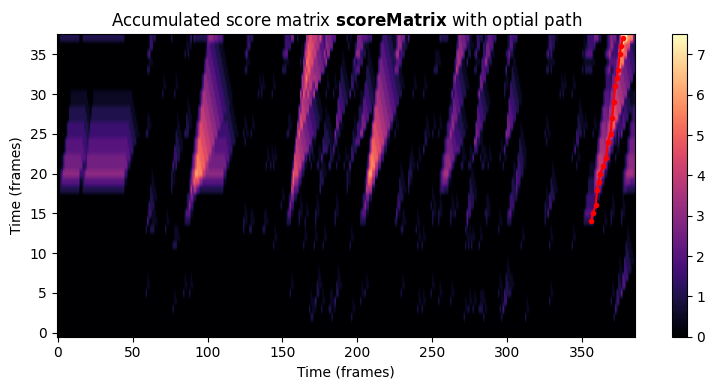

In [102]:
figsize = (8, 4)  # 'gray_r'
score = results[query]["res"][idx]["scoreMatrix"]
LibFMP.B.plot_matrix(score, figsize=figsize, cmap="magma", 
                     Fs=1, Fs_F=1, aspect='auto', dpi=100,
                     title='Accumulated score matrix $\mathbf{scoreMatrix}$ with optial path', 
                     xlabel='Time (frames)', 
                     ylabel='Time (frames)')
plt.plot(P[:, 1], P[:, 0], marker='.', color='r')
plt.tight_layout()
plt.show()

In [85]:
n, m = divmod(np.argmax(score), score.shape[1])
P = [(n, m)]

In [88]:
print(P)
print(np.argmax(score))

[(37, 377)]
14659
